In [16]:
import os
from pathlib import Path

import ee
import geemap
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import rasterio as rio
import rasterio.mask as rio_mask
import seaborn as sns

In [17]:
SMOD_COLOR_MAP = {
    "Rural": "#3CB371",
    "Zona urbana": "#FFA500",
    "Centro urbano": "#CD5C5C",
}

DYNAMIC_WORLD_COLOR_MAP = {
    "Agua": "#419bdf",
    "Árboles": "#397d49",
    "Pastizales": "#88b053",
    "Vegetación inundada": "#7a87c6",
    "Cultivos": "#e49635",
    "Construido": "#c4281b",
    "Matorrales y arbustos": "#dfc35a",
}

In [18]:
ee.Initialize(project="ee-ursa-test")

In [19]:
data_path = Path(os.environ["DATA_PATH"])
ghsl_path = Path(os.environ["GHSL_PATH"])
figure_path = Path("./fig")

In [20]:
df_bounds = gpd.read_file(data_path / "area_de_estudio" / "d_160101_ambito_estudio.shp")
crs = df_bounds.estimate_utm_crs()
df_bounds = df_bounds.to_crs(crs)

In [21]:
bounds = df_bounds.to_crs("ESRI:54009")["geometry"].item()

In [22]:
bounds_latlon = (
    df_bounds.assign(geometry=lambda df: df["geometry"].simplify(100))
    .to_crs("EPSG:4326")["geometry"]
    .item()
)

bounds_ee = ee.geometry.Geometry.Polygon(list(bounds_latlon.exterior.coords))

# Population

In [23]:
rows = []
for year in range(1975, 2021, 5):
    with (
        rio.open(ghsl_path / "POP_1000" / f"{year}.tif", nodata=0) as ds_pop,
        rio.open(ghsl_path / "SMOD_1000" / f"{year}.tif", nodata=-200) as ds_smod,
    ):
        pop, _ = rio_mask.mask(ds_pop, [bounds], crop=True, nodata=0)
        smod, _ = rio_mask.mask(ds_smod, [bounds], crop=True, nodata=-200)

        pop = pop.squeeze()

        smod = smod.squeeze()
        smod[smod == -200] = 0
        smod = smod // 10

    count = np.bincount(smod.flatten(), weights=pop.flatten())
    for smod_val in range(4):
        try:
            dpop = count[smod_val]
        except IndexError:
            dpop = 0
        rows.append({"year": year, "smod": smod_val, "pop": dpop})

df_pop = (
    pd.DataFrame(rows)
    .query("smod != 0")
    .pivot_table(index="year", columns="smod", values="pop", fill_value=0)
    .rename(columns={1: "Rural", 2: "Zona urbana", 3: "Centro urbano"})
)

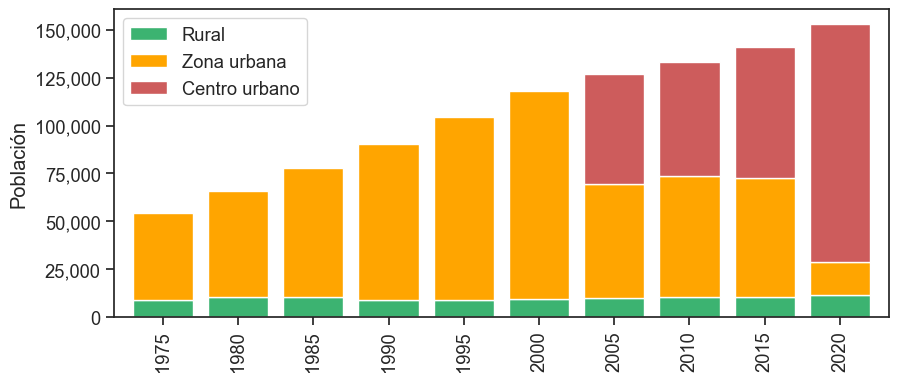

In [24]:
sns.set_theme(style="ticks", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 4))
df_pop.plot.bar(stacked=True, width=0.8, ax=ax, color=SMOD_COLOR_MAP)
ax.set_xlabel("")
ax.set_ylabel("Población")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
ax.legend(title=None)
fig.savefig(figure_path / "pop.jpg", bbox_inches="tight", dpi=300)

# Built

## Area

In [25]:
built_areas = []
built_arr = []

for year in range(1975, 2021, 5):
    with rio.open(ghsl_path / "BUILT_100" / f"{year}.tif", nodata=0) as ds:
        profile = ds.profile
        built, transform = rio_mask.mask(ds, [bounds], crop=True, nodata=0)
        built = built.squeeze()

    built_areas.append({"year": year, "area": built.astype(float).sum()})

    mask = (built >= (0.2 * 100 * 100)) * year
    built_arr.append(mask)

df_area = (
    pd.DataFrame(built_areas, columns=["year", "area"]).set_index("year").divide(1e6)
)

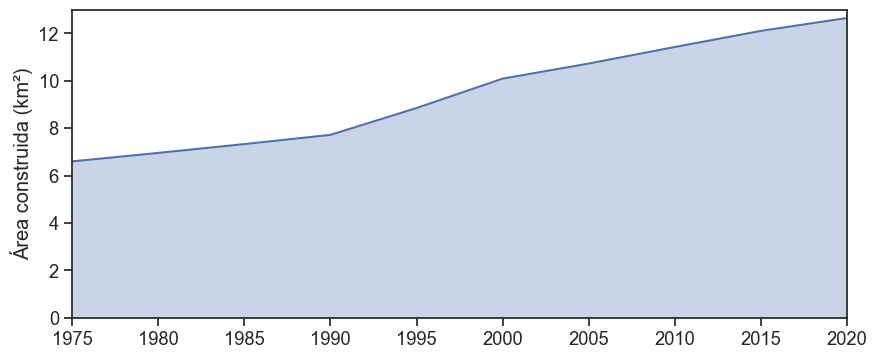

In [26]:
sns.set_theme(font_scale=1.2, style="ticks")

fig, ax = plt.subplots(figsize=(10, 4))
df_area.plot(ax=ax, legend=False)
ax.fill_between(df_area.index, df_area["area"], alpha=0.3)

ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

ax.set_xlabel("")
ax.set_ylabel("Área construida (km²)")

ax.set_xlim(1975, 2020)
ax.set_ylim(0, 13)
fig.savefig(figure_path / "built_area.jpg", bbox_inches="tight", dpi=300)

In [27]:
print(df_area.diff().iloc[1:].to_latex())

\begin{tabular}{lr}
\toprule
 & area \\
year &  \\
\midrule
1980 & 0.357643 \\
1985 & 0.372604 \\
1990 & 0.389512 \\
1995 & 1.132988 \\
2000 & 1.240055 \\
2005 & 0.637509 \\
2010 & 0.697805 \\
2015 & 0.680560 \\
2020 & 0.543733 \\
\bottomrule
\end{tabular}



In [46]:
built_arr = []

for year in range(1975, 2021, 5):
    with rio.open(ghsl_path / "BUILT_100" / f"{year}.tif", nodata=0) as ds:
        profile = ds.profile
        built, transform = rio_mask.mask(ds, [bounds], crop=True, nodata=65535)
        built = built.squeeze()
        built_arr.append(built)

        crs = ds.crs

built_arr = np.array(built_arr).astype(np.uint16)

with rio.open(
    "./rasters/built_area.tif",
    "w",
    driver="GTiff",
    height=built_arr.shape[1],
    width=built_arr.shape[2],
    count=built_arr.shape[0],
    dtype=built_arr.dtype,
    crs=crs,
    transform=transform,
    nodata=65535,
) as ds:
    ds.write(built_arr)

## Year

In [28]:
built_arr = np.array(built_arr).astype(float)
built_arr[built_arr == 0] = np.nan
built_arr = np.nanmin(built_arr, axis=0)
built_arr[np.isnan(built_arr)] = 0
built_arr = built_arr.astype(np.uint16)

/var/folders/yq/0mz24vy927s9m5vjh6gqb6040000gn/T/ipykernel_16512/3285329835.py:3: RuntimeWarning: All-NaN slice encountered
  built_arr = np.nanmin(built_arr, axis=0)


In [29]:
with rio.open(
    "./rasters/built_year.tif",
    "w",
    height=built_arr.shape[0],
    width=built_arr.shape[1],
    count=1,
    dtype="uint16",
    crs="ESRI:54009",
    transform=transform,
    compress="lzw",
    nodata=0,
) as ds:
    ds.write(built_arr, 1)

# Land cover

In [30]:
land_cover_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]

In [34]:
rows = []
for year in range(2016, 2025):
    img = (
        ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filterBounds(bounds_ee)
        .filterDate(f"{year}-01-01", f"{year}-12-31")
        .select("label")
        .mode()
        .clip(bounds_ee)
    )

    img_area = ee.image.Image.pixelArea().addBands(img)

    reduced = img_area.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName="label"),
        geometry=bounds_ee,
        scale=30,
        maxPixels=1e9,
    ).getInfo()

    groups = reduced["groups"]
    for group in groups:
        group["year"] = year

    rows.extend(groups)

    geemap.download_ee_image(
        img,
        f"./rasters/land_cover/{year}.tif",
        scale=30,
        region=bounds_ee,
        crs="EPSG:4326",
        unmask_value=99,
    )

df_land_cover = (
    pd.DataFrame(rows)
    .assign(
        label=lambda df: df["label"].map(
            {i: land_cover_labels[i] for i in range(len(land_cover_labels))},
        ),
    )
    .pivot_table(index="year", columns="label", values="sum", fill_value=0)
)

2016.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2017.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2018.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2019.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2020.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2021.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2022.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2023.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

2024.tif: |          | 0.00/1.83M (raw) [  0.0%] in 00:00 (eta:     ?)

In [41]:
land_cover_agg = []
for year in range(2016, 2025):
    with rio.open(f"./rasters/land_cover/{year}.tif", nodata=99) as ds:
        land_cover_agg.append(ds.read(1))
        transform = ds.transform
        crs = ds.crs

land_cover_agg = np.array(land_cover_agg).astype(np.uint8)

with rio.open(
    "./rasters/land_cover.tif",
    "w",
    driver="GTiff",
    height=land_cover_agg.shape[1],
    width=land_cover_agg.shape[2],
    count=land_cover_agg.shape[0],
    dtype=land_cover_agg.dtype,
    crs=ds.crs,
    transform=ds.transform,
    nodata=99
) as ds:
    ds.write(land_cover_agg)

In [39]:
land_cover_agg

array([[[99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        ...,
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99]],

       [[99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        ...,
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99]],

       [[99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        ...,
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99]],

       ...,

       [[99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        ...,
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99, 99],
        [99, 99, 99, ..., 99, 99

In [ ]:
unwanted_classes = (df_land_cover.divide(df_land_cover.sum(axis=1), axis=0) < 0.01).all(
    axis=0,
)
df_land_cover_filtered = (
    df_land_cover.loc[:, ~unwanted_classes]
    .rename(
        columns={
            "bare": "Baldío",
            "built": "Construido",
            "crops": "Cultivos",
            "flooded_vegetation": "Vegetación inundada",
            "grass": "Pastizales",
            "shrub_and_scrub": "Matorrales y arbustos",
            "snow_and_ice": "Nieve y hielo",
            "trees": "Árboles",
            "water": "Agua",
        },
    )
    .divide(1e6)
)

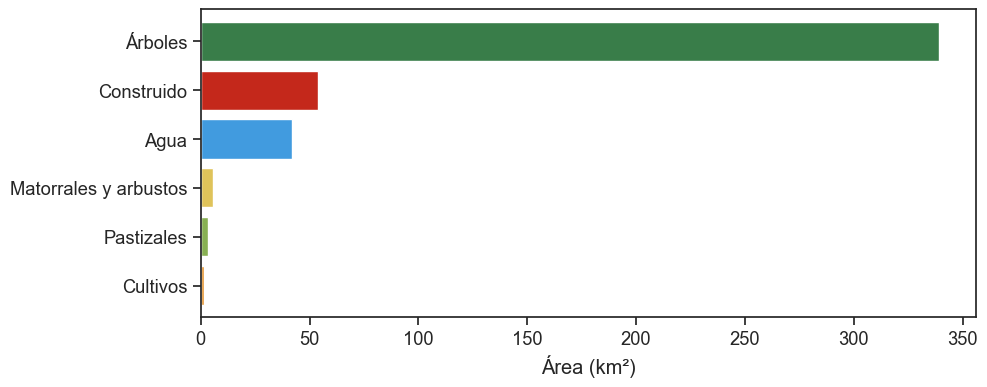

In [ ]:
sns.set_theme(font_scale=1.2, style="ticks")

temp = df_land_cover_filtered.loc[2024].sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 4))
temp.plot.barh(
    color=[DYNAMIC_WORLD_COLOR_MAP[label] for label in temp.index], width=0.8,
)
ax.set_xlabel("Área (km²)")
ax.set_ylabel("")
fig.savefig(figure_path / "land_cover_2024.jpg", bbox_inches="tight", dpi=300)

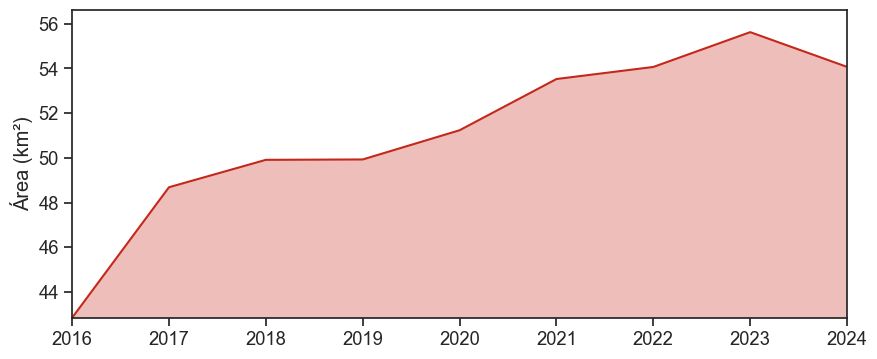

In [ ]:
sns.set_theme(style="ticks", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 4))
df_land_cover_filtered["Construido"].plot(ax=ax, c=DYNAMIC_WORLD_COLOR_MAP["Construido"])
ax.fill_between(
    df_land_cover_filtered.index, df_land_cover_filtered["Construido"], alpha=0.3, facecolor=DYNAMIC_WORLD_COLOR_MAP["Construido"]
)
ax.set_xlabel("")
ax.set_ylabel("Área (km²)")
ax.set_xlim(2016, 2024)
ax.set_ylim(
    df_land_cover_filtered["Construido"].min(),
    df_land_cover_filtered["Construido"].max() + 1,
)
fig.savefig(figure_path / "land_cover_construido.jpg", bbox_inches="tight", dpi=300)

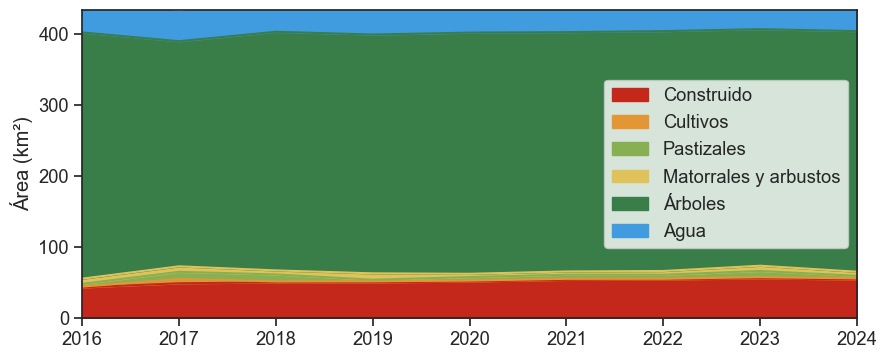

In [ ]:
sns.set_theme(font_scale=1.2, style="ticks")

fig, ax = plt.subplots(figsize=(10, 4))
df_land_cover_filtered.plot.area(ax=ax, color=DYNAMIC_WORLD_COLOR_MAP)
ax.legend(title=None)
ax.set_xlabel("")
ax.set_ylabel("Área (km²)")
ax.set_xlim(2016, 2024)
ax.set_ylim(0, 434)

fig.savefig(figure_path / "land_cover.jpg", bbox_inches="tight", dpi=300)

In [ ]:
print(df_land_cover_filtered["Construido"].diff().iloc[1:].to_latex(float_format="%.1f"))

\begin{tabular}{lr}
\toprule
 & Construido \\
year &  \\
\midrule
2017 & 5.8 \\
2018 & 1.2 \\
2019 & 0.0 \\
2020 & 1.3 \\
2021 & 2.3 \\
2022 & 0.5 \\
2023 & 1.6 \\
2024 & -1.6 \\
\bottomrule
\end{tabular}



In [ ]:
m = geemap.Map(center=[-3.75, -73.25], zoom=10, height=800)
m.addLayer(img)
m

Map(center=[-3.75, -73.25], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright…